In [1]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

random_state = 33

/Users/katecastillo/.pyenv/versions/3.11.9/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("../../../data/customer_churn_telecom_services.csv")
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df.columns = df.columns.str.lower()
df.head()

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
cat_cols = [
    "gender", "partner", "dependents", "phoneservice", "multiplelines", 
    "internetservice", "onlinesecurity", "onlinebackup", "deviceprotection",
    "techsupport", "streamingtv", "streamingmovies", "contract", "paperlessbilling",
    "paymentmethod", "churn"
]

# encoder = LabelEncoder()
# df[cat_cols] = df[cat_cols].apply(lambda col: encoder.fit_transform(col))

In [5]:
df_model = df.copy()

In [6]:
label_encoders = {}
for col in cat_cols:
    encoder = LabelEncoder()
    df_model[col] = encoder.fit_transform(df_model[col])
    label_encoders[col] = {index: label for index, label in enumerate(encoder.classes_)}

In [7]:
label_encoders

{'gender': {0: 'Female', 1: 'Male'},
 'partner': {0: 'No', 1: 'Yes'},
 'dependents': {0: 'No', 1: 'Yes'},
 'phoneservice': {0: 'No', 1: 'Yes'},
 'multiplelines': {0: 'No', 1: 'No phone service', 2: 'Yes'},
 'internetservice': {0: 'DSL', 1: 'Fiber optic', 2: 'No'},
 'onlinesecurity': {0: 'No', 1: 'No internet service', 2: 'Yes'},
 'onlinebackup': {0: 'No', 1: 'No internet service', 2: 'Yes'},
 'deviceprotection': {0: 'No', 1: 'No internet service', 2: 'Yes'},
 'techsupport': {0: 'No', 1: 'No internet service', 2: 'Yes'},
 'streamingtv': {0: 'No', 1: 'No internet service', 2: 'Yes'},
 'streamingmovies': {0: 'No', 1: 'No internet service', 2: 'Yes'},
 'contract': {0: 'Month-to-month', 1: 'One year', 2: 'Two year'},
 'paperlessbilling': {0: 'No', 1: 'Yes'},
 'paymentmethod': {0: 'Bank transfer (automatic)',
  1: 'Credit card (automatic)',
  2: 'Electronic check',
  3: 'Mailed check'},
 'churn': {0: 'No', 1: 'Yes'}}

In [8]:
df.dtypes

gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure                int64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges        float64
churn                object
dtype: object

In [9]:
df_model.dropna(inplace=True)

In [10]:
df_model.isna().sum()

gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

In [11]:
df_model.churn.value_counts()

churn
0    5163
1    1869
Name: count, dtype: int64

In [12]:
X = df_model.drop(["churn"], axis=1)
y = df_model["churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [13]:
smote = SMOTE(random_state=random_state)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

In [15]:
model = CatBoostClassifier()
model.fit(X_train_scaled, y_train_resampled)

Learning rate set to 0.025377
0:	learn: 0.6774642	total: 59.6ms	remaining: 59.5s
1:	learn: 0.6623766	total: 62.9ms	remaining: 31.4s
2:	learn: 0.6476056	total: 67.4ms	remaining: 22.4s
3:	learn: 0.6360121	total: 69.3ms	remaining: 17.3s
4:	learn: 0.6247188	total: 71.4ms	remaining: 14.2s
5:	learn: 0.6117236	total: 73.5ms	remaining: 12.2s
6:	learn: 0.6018731	total: 76ms	remaining: 10.8s
7:	learn: 0.5931330	total: 80.5ms	remaining: 9.98s
8:	learn: 0.5846870	total: 82.8ms	remaining: 9.12s
9:	learn: 0.5751753	total: 85ms	remaining: 8.41s
10:	learn: 0.5658265	total: 87.1ms	remaining: 7.83s
11:	learn: 0.5579797	total: 91ms	remaining: 7.49s
12:	learn: 0.5508878	total: 95.4ms	remaining: 7.24s
13:	learn: 0.5443597	total: 105ms	remaining: 7.42s
14:	learn: 0.5381362	total: 120ms	remaining: 7.86s
15:	learn: 0.5298636	total: 131ms	remaining: 8.04s
16:	learn: 0.5242190	total: 133ms	remaining: 7.68s
17:	learn: 0.5177395	total: 135ms	remaining: 7.37s
18:	learn: 0.5125777	total: 137ms	remaining: 7.08s
19:	

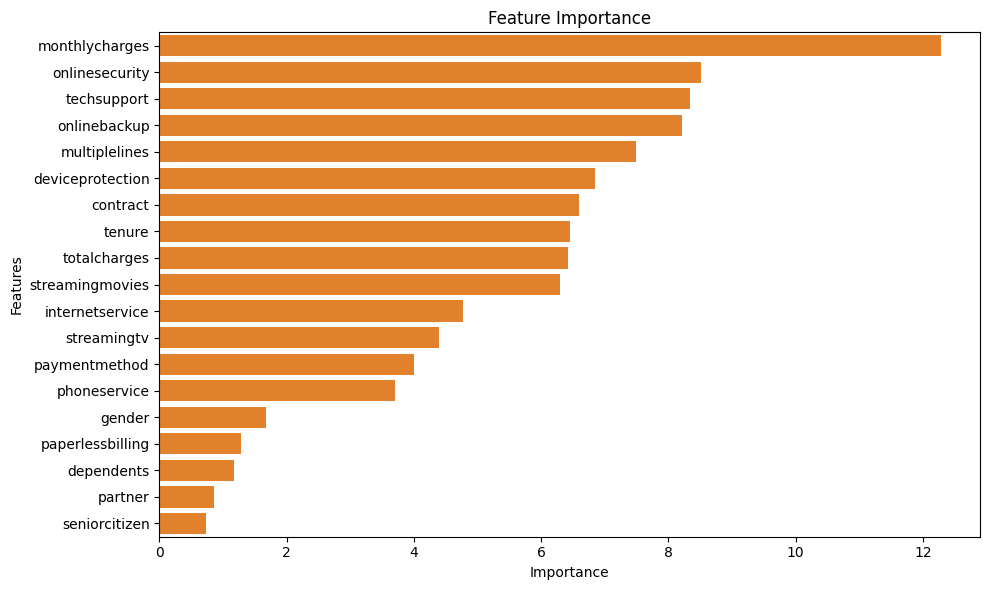

In [16]:
feature_importance = model.get_feature_importance()
feature_names = X_train.columns

cat_boost_importance = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=cat_boost_importance["Importance"], y=cat_boost_importance["Feature"])
fig = sns.barplot(x=cat_boost_importance["Importance"], y=cat_boost_importance["Feature"]).get_figure()
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig("Catboost_feature_importance.png", dpi=200)
plt.show()

In [17]:
X_train_scaled_cols = pd.DataFrame(X_train_scaled, columns=X_train.columns)

explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train_scaled_cols)

In [27]:
label_encoders["dependents"]

{0: 'No', 1: 'Yes'}

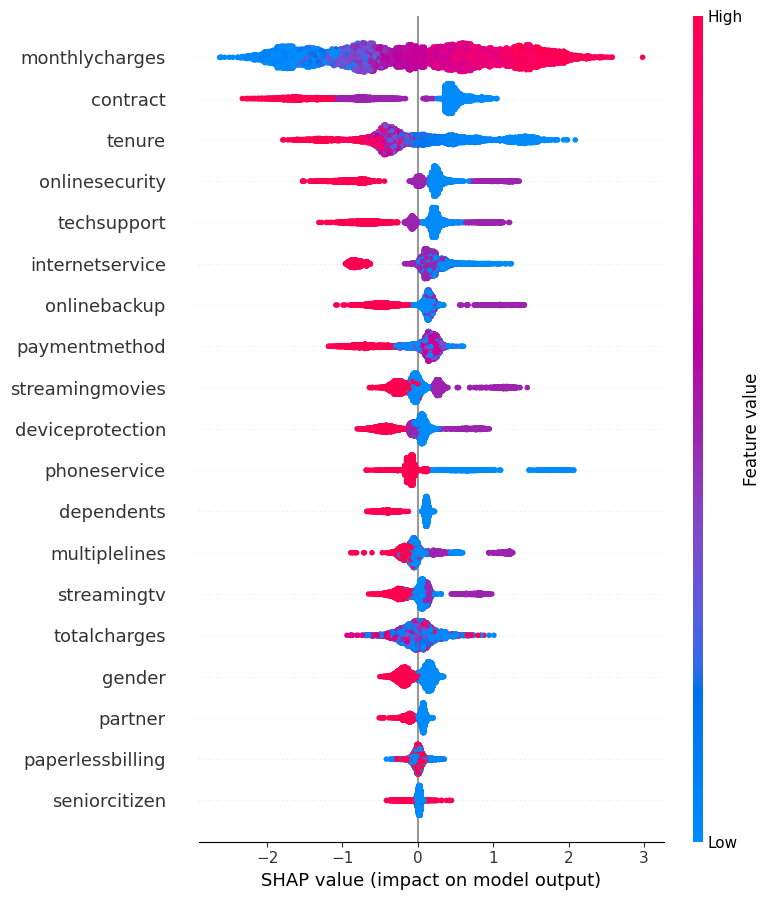

In [25]:
shap.summary_plot(shap_values, X_train_scaled_cols)

In [18]:
label_encoders

{'gender': {0: 'Female', 1: 'Male'},
 'partner': {0: 'No', 1: 'Yes'},
 'dependents': {0: 'No', 1: 'Yes'},
 'phoneservice': {0: 'No', 1: 'Yes'},
 'multiplelines': {0: 'No', 1: 'No phone service', 2: 'Yes'},
 'internetservice': {0: 'DSL', 1: 'Fiber optic', 2: 'No'},
 'onlinesecurity': {0: 'No', 1: 'No internet service', 2: 'Yes'},
 'onlinebackup': {0: 'No', 1: 'No internet service', 2: 'Yes'},
 'deviceprotection': {0: 'No', 1: 'No internet service', 2: 'Yes'},
 'techsupport': {0: 'No', 1: 'No internet service', 2: 'Yes'},
 'streamingtv': {0: 'No', 1: 'No internet service', 2: 'Yes'},
 'streamingmovies': {0: 'No', 1: 'No internet service', 2: 'Yes'},
 'contract': {0: 'Month-to-month', 1: 'One year', 2: 'Two year'},
 'paperlessbilling': {0: 'No', 1: 'Yes'},
 'paymentmethod': {0: 'Bank transfer (automatic)',
  1: 'Credit card (automatic)',
  2: 'Electronic check',
  3: 'Mailed check'},
 'churn': {0: 'No', 1: 'Yes'}}